# Simple Synthetic Data RL Trading.

In this notebook we will be creating a reinforcement learning environment from the gym open AI platform, which will set the basis for the reinforcement learning agent. We assume the price to be a simple sine wave. 
This task is done for the following reasons:

- Get familiar with RL environment construction
- See if an agent learns the fundamental of trading: 'buy low, sell high' with deep Q-Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import random
import copy
import torch
import torch.nn.functional as F
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm

import gym 
from gym import spaces



plt.style.use('seaborn')

In [2]:
# Create timestamps

time = np.arange(0, 50, 0.1) # 50 steps splitted into 0.1

# Construct function

amplitude = np.sin(time)

# Construct time series

amplitude = amplitude + 1

# Normalize data

max_amplitude = max(amplitude)

amplitude = amplitude / max_amplitude

# Construct DataFrame

df = pd.DataFrame(amplitude)
df.columns = ['price']
df['returns'] = df.price.pct_change()
df = df.replace(np.inf, np.nan)
df = df.interpolate()
df = df.reset_index(drop=True)
df.dropna(inplace=True)

df.head(10)

,price,returns
1,0.549918,0.099833
2,0.599337,0.089864
3,0.647762,0.080799
4,0.694711,0.072479
5,0.739715,0.064780
6,0.782324,0.057601
7,0.822111,0.050858
8,0.858681,0.044482
9,0.891666,0.038414
10,0.920738,0.032604


<AxesSubplot:title={'center':'Sine Wave Price'}>

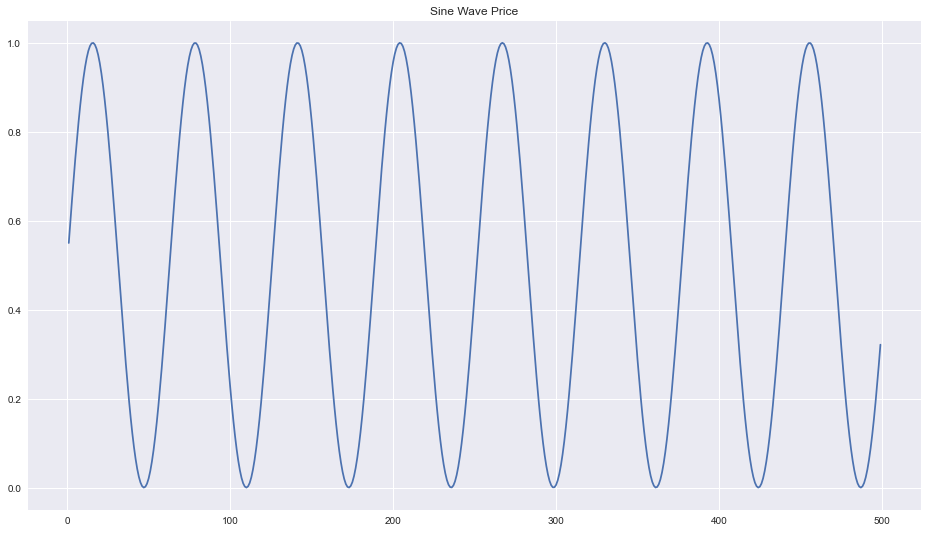

In [3]:
df.price.plot(figsize = (16,9), title = 'Sine Wave Price')

Essentially the agent should learn how to make profits on this simple path, that is buy when the price reaches the minima and sell it off when the price reaches the maxima. To do so, we will need to create a RL environment.


In order to keep things simple we will initialize some variables such as some constraints like:

- MAX_OPEN_POSITIONS, PERCENT_CAPITAL, KILL_THRESH

the above are for *risk management*, namely the percent_capital will tell how much profit should it take from a trade, and the kill threshold will be a stop trading if the agent is loosing too much from the initial capital.

Some other informative variables:

- INITIAL_ACCOUNT_BALANCE, TRADING_COST_RATE

In [4]:
MAX_INT = 123123345

MAX_OPEN_POSITIONS = 1
PERCENT_CAPITAL = 0.1
KILL_THRESH = 0.4

INITIAL_ACCOUNT_BALANCE = 1000
TRADING_COSTS_RATE = 0.001

In [10]:
# Build the Environment Class

class SimpleTradingEnv(gym.Env):
    
    metadata = {'reder.modes': ['human']}
    
    def __init__(self, df):
        super(SimpleTradingEnv, self).__init__()
        # Data Variables
        self.df = df
        
        # Account Variables, keep track of trading
        
        self.account_balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.realized_profit = 0
        self.unrealized_profit = 0
        self.last_profit = 0
        
        # Position Variables
        
        self.open_quantities = []
        self.open_prices = []
        self.trading_costs = 0
        self.open_positions = 0
        self.closed_positions = 0
        self.incorrect_positions_calls = 0
        self.num_trades = 0
        self.hold_for_period = 0
        
        # Current Step
        
        self.current_step = 0
        self.max_steps = len(df)
        
        # Actions, will be discrete actions BUY, HOLD, SELL
        
        self.action_space = spaces.Discrete(3)
        
        # Setup observation space (continuous obs space):
        # we will give the price, the returns of the price, returns -1 step, returns -2 step
        # returns -3 step, returns - 4 steps, current_position and number of trades.
        
        self.observation_space = spaces.Box(low = -1., high= 1., shape=(8,), dtype = np.float32)
        
        
        # We will start to build the Reward Structure:
        
        # Need an helper method to compute rewards
        
    def _compute_reward(self):

        reward = 0

        if self.num_trades:

            reward += self.realized_profit / self.num_trades # encourage not overtrading
            reward += self.unrealized_profit / self.num_trades * 0.3 # incentivize closing trades for profit
            reward += 1 if self.last_profit > 0 else 0
            reward -= 1 if self.incorrect_positions_calls > 0 else 0

        if reward <= 0: # penalize for being too passive i.e. not trading
            reward -= 2

        return reward

    # Need an helper method to build the observation structure


    def _next_observation(self):

        close_item = self.df.loc[self.current_step, 'price'].item()
        close_rets_item = self.df.loc[self.current_step, 'returns'].item()
        close_T1_item = self.df.loc[self.current_step - 1, 'returns'].item()
        close_T2_item = self.df.loc[self.current_step - 2, 'returns'].item()
        close_T3_item = self.df.loc[self.current_step - 3, 'returns'].item()
        close_T4_item = self.df.loc[self.current_step - 4, 'returns'].item()

        current_position = 1 if self.open_positions else 0
        num_trades = self.num_trades / len(self.df) if self.num_trades > 0. else 0

        obs = np.array([close_item, close_rets_item,
                        close_T1_item, close_T2_item,
                        close_T3_item, close_T4_item,
                        current_position, num_trades
                      ])

        return obs


    # helper method for open positions

    def _compute_open_value(self):

        open_trades_value = 0
        counts = 0

        for qty in self.open_quantities:
            acquisition_price = self.open_prices[counts]
            open_trades_values += acquisition_price * qty
            counts += 1

        return open_trades_value


    # helper method to compute net profit

    def _profit_computation(self, current_price: float, pos_type: str) -> float:

        open_trades_value = self._compute_open_value()
        total_quantity_hold = sum(self.open_quantities)
        current_value = total_quantity_hold * current_price
        gross_profit = current_value - open_trades_value

        if pos_type == 'close_position':

            trading_costs = current_value * TRADING_COSTS_RATE
            self.trading_costs += trading_costs

        elif pos_type == 'hold_position' or pos_type == 'open_position':
            trading_costs = open_trades_value * TRADING_COSTS_RATE


        net_profit = gross_profit - trading_costs


    # helper method for Action Management

    def _take_action(self, action):

        current_price = self.df.loc[self.current_step, 'price'].item()

        # reset last profit

        self.last_profit = 0
        self.incorrect_position_calls = 0

        # buy

        if action == 0:

            if self.open_positions < MAX_OPEN_POSITIONS:

                net_profit = self._profit_computation(current_price, 'open_position')
                net_worth = self.net_worth + net_profit
                trading_allowance = net_worth * PERCENT_CAPITAL
                
                self.open_quantities.append(trading_allowance / current_price)
                self.open_prices.append(current_price)
                self.trading_costs += trading_allowance * TRADING_COSTS_RATE
                self.num_trades += 1


            else:

                self.incorrect_positions_calls +=1


        # Hold

        if action == 1:

            net_profit = self._profit_computation(current_price, 'hold_position')
            self.unrealized_profit += net_profit

            if self.open_positions > 0:
                self.hold_for_period += 1


        # SELL

        if action == 2:

            if self.open_positions != 0:

                net_profit = self._profit_computation(current_price, 'close_position')
                self.last_profit = net_profit
                self.realized_profit += net_profit
                # since closed everything needs reinitialization
                self.unrealized_profit = 0
                self.open_quantities = []
                self.open_prices = []
                self.hold_for_period = 0

                self.closed_positions +=1

            else:
                self.incorrect_positions_calls += 1

        # Update Variables


        open_trades_value = self._compute_open_value()
        self.open_positions = len(self.open_quantities)
        self.net_worth = INITIAL_ACCOUNT_BALANCE + self.unrealized_profit + self.realized_profit
        self.available_balance = INITIAL_ACCOUNT_BALANCE - open_trades_value + self.realized_profit



    # Step function

    def step(self, action):

        self._take_action(action)

        reward = self._compute_reward()

        self.current_step +=1

        is_max_steps_taken = self.current_step >= self.max_steps - 1
        is_account_balance_reached = self.net_worth <= INITIAL_ACCOUNT_BALANCE * KILL_THRESH

        done = True if is_max_steps_taken or is_account_balance_reached else False

        obs = self._next_observation()

        return obs, reward, done, {}
    
    
    # Reset Environment
    
    def reset(self):
        
        self.account_balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.realized_profit = 0
        self.unrealized_profit = 0
        self.open_quantities = []
        self.open_prices = []
        self.trading_costs = 0
        self.open_positions = 0
        self.incorrect_positions_calls = 0
        self.current_step = 5  # because our observation is looking back 5 steps in sequence

        return self._next_observation()
        
    
    # Render the environment to the screen
    
    def render(self, mode = 'human', close = False):
        
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE
        
        return profit
    

In [19]:
env = SimpleTradingEnv(df)
observation = env.reset()

print('Initial Observation: {}'.format(observation))

Initial Observation: [0.73971508 0.06478049 0.0724791  0.08079866 0.08986444 0.09983342
 0.         0.        ]


In [20]:
# Test Environment
env = SimpleTradingEnv(df)
actions = [0,1,2]
observation = env.reset()
print("Initial Observation: ", env.reset())

for action in actions:
    next_step, reward, done, info = env.step(action)
    print("TESTING ENVIRONMENT")
    print("="*80)
    print("Action Taken: ", action)
    print("Reward Received : ", reward)
    print("Next State: ", next_step)
    print("Completed: ", done)
    print("-"*80)
    print("Available Balance: ", env.available_balance)
    print("Net Worth : ", env.net_worth)
    print("Realized Profit: ", env.realized_profit)
    print("Unrealized Profit: ", env.unrealized_profit)
    print("Open Quantities: ", env.open_quantities)
    print("Open Prices: ", env.open_prices)
    print("Trading Costs: ", env.trading_costs)
    print("Open Positions: ", env.open_positions)
    print("Incorrect Calls: ", env.incorrect_position_calls)
    print("-"*80)

Initial Observation:  [0.73971508 0.06478049 0.0724791  0.08079866 0.08986444 0.09983342
 0.         0.        ]
TESTING ENVIRONMENT
Action Taken:  0
Reward Received :  -2.0
Next State:  [0.78232368 0.05760137 0.06478049 0.0724791  0.08079866 0.08986444
 1.         0.00200401]
Completed:  False
--------------------------------------------------------------------------------
Available Balance:  900.0
Net Worth :  1000
Realized Profit:  0
Unrealized Profit:  0
Open Quantities:  [135.18718520595226]
Open Prices:  [0.7397150835536224]
Trading Costs:  0.1
Open Positions:  1
Incorrect Calls:  0
--------------------------------------------------------------------------------
TESTING ENVIRONMENT
Action Taken:  1
Reward Received :  1.6980410382376971
Next State:  [0.82211142 0.0508584  0.05760137 0.06478049 0.0724791  0.08079866
 1.         0.00200401]
Completed:  False
--------------------------------------------------------------------------------
Available Balance:  900.0
Net Worth :  1005.6

## A deep Q-Learning Algorithm for Trading.


In this section we are going to apply a deep q-learning algorithm to the previous environment to see if there is evidence of learning the q-value of maximizing profits.

Before proceeding we will explain the logic behind the algorithm. Loosely speaking a deep Q-Learning algorithm is a combination of a temporal difference method (SARSA) and a neural network. States will be feed into a neural network, learned, and as output we will have the estimated q-values for that state. 

We will compare the estimate of the neural network with the correct value. The difference between these two values is the estimation. If we call $\theta$ the parameters of the neural network, then we would like to minimize the mean squared error (our cost function):

$$ L(\theta) = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i) ^2 $$

The cost function represents the size of the errors. In our specific case the above becomes:

$$ L(\theta) = \frac{1}{|K|} \sum_{i=1}^{|K|} [R_i + \gamma \hat{q}(S_{i}^{'}, A_{i}^{'} | \theta_{targ})   - \hat{q}(S_i, A_i | \theta)] ^2 $$

The target is the value towards which we want to push the estimates and estimate the q-value of state-actions pairs.

More specifically, the target value as in the original source SARSA algorithm, will be the return estimated in one step. That is the reward obtained by executing the action and the discounted value of the action chosen by the policy in the next state. It is this difeerence that we will have to minimize by defining and minimizing the cost function, to do that we will compute the value of the cost function based on a batch of experiences of size $|K|$ taken from the memory. Based on these batches we will compute the estimated q-values and the target values for each state transition and based on them we will compute the cost function.

Once obtained the values of the cost function we will compute its gradient and we will make the stochastic gradient descent step.


In the following picture, taken from Sutton-Barto Introduction to Reinforcement Learning we can see the algorithm



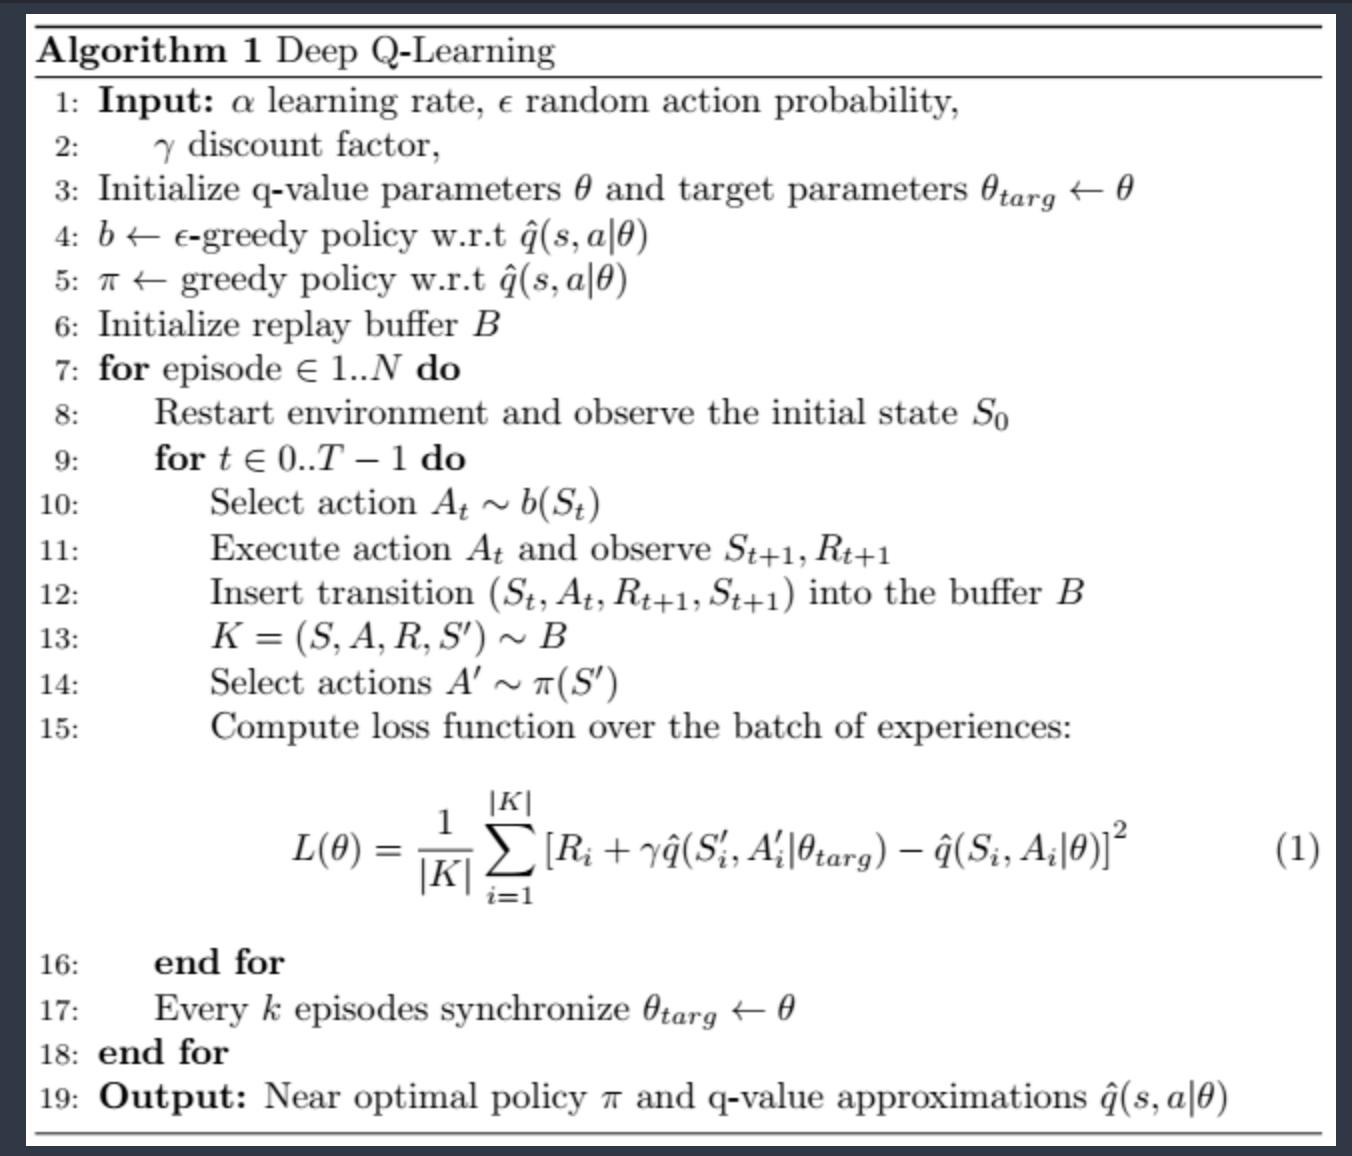

In [76]:
from IPython import display
display.Image("Schermata 2022-12-07 alle 11.35.54.png")


We can see that deep q-learning is an off-policy method, so there are two policies one, $b(s)$ used to explore the environment, and the other $\pi(s)$ to be estimated with a neural network. Another important comment is the *Replay Memory* buffer $B$ that acts as a database that stores the state transitions and rewards that the agent experiences. The memory has a limited size and when it fills up, it replaces old transitions with new ones. In this way, the replay memory will keep a fresh bowl of state transitions.
So, when it is time to update the neural network, we will use the experience that we have stored in the memory. To update the memory we randomly choose a batch of transition from the memory. The size of that batch is arbitrarily chosen by us. The batch of transition is used to calculate the loss function and update the $\theta$-parameters with the above loss function.

Notice that when a value is changed, then also nearby values will be affected. So since the estimates of the q-values will be approaching a moving targetm this process will be unstable for learning. To avoid this we will make a copy of the NN to calculate the targets. The copied NN does not change with the stochastic gradient descent, its $\theta$-parameters remains the same. So this will allow the parameter estimates to remain stable during the learning process. From each $K$ episode, we will copy the parameters from the agent network to the target network.

In [22]:
def seed_everything(env: gym.Env, seed: int = 42) -> None:
    """
    Seeds all the sources of randomness so that experiments are reproducible.
    Args:
        env: the environment to be seeded.
        seed: an integer seed.
    Returns:
        None.
    """
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch._set_deterministic(True)

In [78]:
env = SimpleTradingEnv(df)
seed_everything(env)
state = env.reset()

## Prepare the environment to work with PyTorch

We will be writing a wrapper class inherited from the gym environment to be able to work with pyTorch.

In [79]:
class PreprocessEnv(gym.Wrapper):
    
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    def reset(self):
        obs = self.env.reset()
        return torch.from_numpy(obs).unsqueeze(dim=0).float()
    
    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

In [80]:
env = PreprocessEnv(env)

In [81]:
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, info = env.step(action)
print(f"Sample state: {state}")
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")

Sample state: tensor([[0.7397, 0.0648, 0.0725, 0.0808, 0.0899, 0.0998, 0.0000, 0.0000]])
Next state: tensor([[0.7823, 0.0576, 0.0648, 0.0725, 0.0808, 0.0899, 1.0000, 0.0020]]), Reward: tensor([[-2.]]), Done: tensor([[False]])


## Create the Q-Network and Policy

As stated before the q_network will be represented by a deep neural network.

In [82]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n

In [83]:
q_network = nn.Sequential(
    
    nn.Linear(state_dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions)
)

In [84]:
# Create the target Q-Network with the copy method

target_q_network = copy.deepcopy(q_network).eval()

In [85]:
# Create exploratory policy b(s), this is an epsilon-greedy policy

def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1,1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

In [86]:
# Create the Experience Replay buffer

class ReplayMemory:
    
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

In [89]:
# The deep_q_learning algorithm

def deep_q_learning(q_network, policy, episodes, 
                    alpha=0.001, batch_size=24, gamma=0.99, epsilon=0.25):
    
    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory()
    stats = {'MSE Loss': [], 'Returns': []}
    
    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()
        done = False
        ep_return = 0
        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, info = env.step(action)
            
            memory.insert([state, action, reward, done, next_state])
            
            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)              
                qsa_b = q_network(state_b).gather(1, action_b)
                
                next_qsa_b = target_q_network(next_state_b)
                next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0]
                
                target_b = reward_b + ~done_b * gamma * next_qsa_b
                loss = F.mse_loss(qsa_b, target_b)
                q_network.zero_grad()
                loss.backward()
                optim.step()
                
                stats['MSE Loss'].append(loss.item())  
                
            state = next_state
            ep_return += reward.item()
            
        
        stats['Returns'].append(ep_return)
        
        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())

    return stats

In [90]:
stats = deep_q_learning(q_network, policy, episodes = 500)

100%|█████████████████████████████████████████| 500/500 [10:46<00:00,  1.29s/it]


In [92]:
def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()

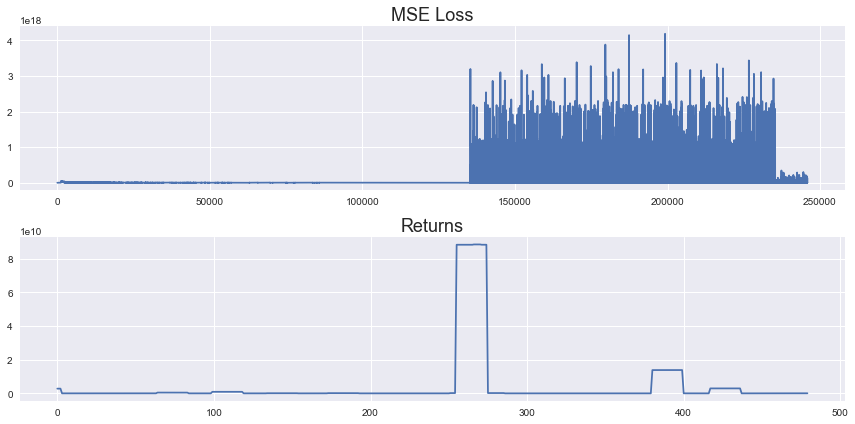

In [93]:
plot_stats(stats)